# TCGA Survival Analysis

**This analysis is based on the new interface implemented in `interface.py` and the functions in `DSA_utils.py`.**

In this notebook we analyze the effect of mutations on patients survival over all cancer types and all TCGA therapies.

Two operation modes are supported:
1. Analyze an abritrary list of mutations.
2. Analyze all mutations of a given gene.

In general, given a list of TCGA mutations, the code analyzes the effect on survival over all cancer types and therapies, and reports the significant cases. Logrank test and Cox hazard model test are used to estimate the statistical difference between two groups of patients. In addition, a bootstrapping procedure is used, which controls for group sizes mismatch.

Usage:
- Run the section `Initialization` (should be executed only once when performing multiple testing). Modify the parameters in this section if needed.
- Set the parameters in the `Parameters` section.
- Execute the section `Run` to run the test.
- Optional: execute the section `Plot a Result` to plot the two groups survival curves of a result.

## Description

We perform differential survival (DS) analysis based on a given `mutation`. The DS analysis compares the survival between two groups of patients, over all `cancer` types and all `therapy` types in the TCGA data, and produces a p-value for the null hypothesis that the survival in the two groups is the same.

A test configuration, which defines a  DS test, contains the two group configurations. Each group configuration is a three-letter sequence, indicating the inclusion (capital letter) of exclusion (lower-case letter) of the `mutation`, `cancer`, and `therapy`, respectively, in the group of patients. For example, `MCT` defines a group of patients with the `mutation`, of `cancer` type that undergo `therapy`, whereas `mCt` defines group of patients **without** the `mutation`, of `cancer` type that **did not** undergo `therapy`. Specifically, `c` (i.e., lower-case c) implies all patients regardless of cancer type (i.e. PAN-cancer), and `t` (i.e. lower-case t) implies patients that did not undergo `therapy`.

The current supported tests are:
1. `MCT-mCT`: A single test. group1 contains all `cancer` patients with the `mutation` that undergo `therapy`, whereas group2 contains all `cancer` patients **without** the `mutation` that undergo `therapy`
1. `McT-mcT`: A single test. group1 contains all patients (PAN-cancer) with the `mutation` that undergo `therapy`, whereas group2 contains all patients (PAN-cancer) **without** the `mutation` that undergo `therapy`
1. `MCT-MCt,mCT-mCt`: Two tests. In the first test, group1 contains all `cancer` patients with the `mutation` that undergo `therapy`, whereas group2 contains all `cancer` patients with the `mutation` that **did not** undergo `therapy`. In the second test, group1 contains all `cancer` patients **without** the `mutation` that undergo `therapy`, whereas group2 contains all `cancer` patients **without** the `mutation` that **did not** undergo `therapy`
1. `MCT-mCT,MCt-mCt`: Two tests. In the first test, group1 contains all `cancer` patients with the `mutation` that undergo `therapy`, whereas group2 contains all `cancer` patients **without** the `mutation` that undergo `therapy`. In the second test, group1 contains all `cancer` patients with the `mutation` that **did not** undergo `therapy`, whereas group2 contains all `cancer` patients **without** the `mutation` that **did not** undergo `therapy`

In general, more tests can easily be supported.

When a configuration contains multiple tests (as in the third and forth tests above), one of the tests can be defined as the `main` test. A `main` test implies, for a given `mutation`, that the tests **following** the `main` test are not executed unless a statistically significant DS was found in at least one `cancer` and/or `therapy` type in the `main` test (for that given `mutation`), in which case only these cases will be evalutaed in the following tests. Thus, a `main` test implies that the order of the tests is important. 

A `main` test is defined by the parameter `Main_test_index`. 
For example, for the `MCT-MCt,mCT-mCt` test and `Main_test_index=1`, the `mCT-mCt` will not be executed if no significant result was found for `MCT-MCt` (for a given mutation).
Set `Main_test_index = <number of tests>` to disable this behavior.

## Reports

For each test, the analysis generates two report files containing the `mutation`, `cancer` and `therapy` values that resulted in a statistically significant DS (non-significant results are not reported). Each report file includes the two group sizes, p values, and AUCs.
The report files are:
- A pickle file containing a dictionary with all the analysis data.
- An excel file containing a summary report, where each row corresponds to a `test configuration` with `mutation`, `cancer` and `therapy` values that caused a significant DS.

## Notes
The analysis below reports and saves only the significant results. If the non-significant results are also required, do the following:
- Define `P_val_threshold` to be large (e.g. `P_val_threshold = 1.0`)
- Run the analysis. All the p-values will be reported and saved.
- Manually select the results that you consider as insignificant.

In case of multiple tests (with `Main_test_index` as the main test), most of the cases will now be considered as significant, thus all the corresponding cases in the tests following the main tests will be executed, implying that the run time will increase.



In [1]:
'''
Global configuration.
'''
import pathlib
import datetime
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# make sure PYTHONPATH is set, containing the Utils folder.
import mysys_init as si
import myutils as myut

from Utils import DSA_utils as ut


# Initialization

Run this section only once, even when running multiple tests multiple times. 


In [2]:
""" 
TCGA Data
"""
from Utils import TCGA_interface as TCGAi
import GDC_dataset_feb2021_utils as gdcu  # needed only TCGA_mutation_data_folder in this cell

# TCGA clinical file
TCGA_clinical_data_file: pathlib.Path = pathlib.Path(si.ROOT_path) / 'Data' / 'GDC' / 'Clinical' / 'df_p_all.pkl'

# TCGA main mutation folder
TCGA_mutation_data_folder: pathlib.Path = pathlib.Path(si.ROOT_path) / 'Data' / 'GDC' / 'Mutations' / 'data' / 'filtered_feb_2021' / 'AllGenes' if si.MACHINE == 'MAC' else pathlib.Path(gdcu.Dataset_main_folder)

# TCGA therapy and drug clinical data dictionary
min_drug_prevalence: int = 20
TCGA_df_clinical_drugs_dict_file_name: pathlib.Path = pathlib.Path(si.ROOT_path) / 'Explore_kaplan_meier' / 'Reports' / 'TCGA_clinical_preprocess' / f'df_clinical_drugs_dict_{min_drug_prevalence}.pkl'

# instantiate TCGA data
Dsa_Mut = TCGAi.TCGA_Mutation_ID()
Dsa_data = TCGAi.TCGA_data(TCGA_mutation_data_folder, TCGA_clinical_data_file, TCGA_df_clinical_drugs_dict_file_name)
Dsa_compute = TCGAi.TCGA_compute()


In [3]:
report_path = pathlib.Path(si.ROOT_path) / 'Explore_kaplan_meier' / 'Develop1' / 'Reports'
results_path = report_path / 'DSA_results'

# therapies to ignore when evaluating the different therapies/drugs in the data
#Ignore_therapies: set = {Dsa_data.None_therapy_name, Dsa_data.All_name, Dsa_data.All_therapies_name}
Ignore_therapies: set = {Dsa_data.None_therapy_name, Dsa_data.All_therapies_name}

# cancer types to ignore. E.g. setting to {'TCGA_GBM', 'TCGA_OV'} will discard patients of these cancer types.
Ignore_cancers: set = set()

In [ ]:
""" 
Debug:Show
"""
print(f"Clinical data")
display(Dsa_data.get_clinical_data())
print(f"patient and cancer columns are {Dsa_data.patient_ID_col} and {Dsa_data.cancer_col}.")
print(f"{Dsa_data.cancer_col} values are: {Dsa_data.get_clinical_data()[Dsa_data.cancer_col].unique().tolist()}")

print(f"\nPatients per cancer:")
a = [(cnr, df_c.shape[0]) for cnr, df_c in Dsa_data.get_clinical_data().groupby(by=Dsa_data.cancer_col)]
df_cancer_prevalence = pd.DataFrame({'Cancer': [x[0] for x in a], 'Num_patients': [x[1] for x in a]}).sort_values('Num_patients', ascending=False).reset_index(drop=True)
df_cancer_prevalence.index += 1
df_cancer_prevalence['Cancer_name'] = df_cancer_prevalence.apply(lambda x: gdcu.Cancer_abbrv2name[f"TCGA_{x['Cancer']}"], axis=1)
df_cancer_prevalence = df_cancer_prevalence[['Cancer', 'Cancer_name', 'Num_patients']]
display(df_cancer_prevalence)

print("\nPatients per therapy:")
df_clinical_therapies_dict = Dsa_data.df_clinical_therapies_dict
df_therapy_prevalence = pd.DataFrame({'Therapy': list(df_clinical_therapies_dict.keys()), 'Num_patients': [x.shape[0] for x in df_clinical_therapies_dict.values()]}).sort_values('Num_patients', ascending=False).reset_index(drop=True)
df_therapy_prevalence.index += 1
display(df_therapy_prevalence)


# Parameters
Set the testing parameters in this section.

Two analysis modes are supported:
- Analysing a given list of arbitrary mutations, by setting the `muts_ids` list.
- Analysing all (possibly filtered) mutations of a given gene, by setting the `gene` string.

**`muts_ids` takes precedence over `gene`, i.e. if `muts_ids` is not an empty list, these mutations will be analyzd, else (`muts_ids` is an empty list), `gene` mutations will be analyzed.**

In [4]:
""" 
Input
"""
# List of mutations
#====================
# list of mutation IDs (with mut_id_cols separated by mut_id_sep)
# muts_ids: list[str] = [
#     'TPX2:chr20:Splice_Region:31770476:G:T',
#     #'FAM193A:chr4:Splice_Site:2695131:T:G',
#     #'MET:chr7:Splice_Site:116739948:A:T',
#     #'PIK3CA:chr3:Intron:179203524:G:C',
#     #'FLT3:chr13:splice_donor_variant:28034299:A:T',
#     'CDON:chr11:Splice_Site:126021246:A:C'
# ]

# update set of splice-altering mutations (with prevalence>=10% in certain cancer types)
muts_ids: list[str] = [
    'TPX2:chr20:Splice_Region:31770476:G:T',
    'MTMR11:chr1:Splice_Site:149935297:A:C',
    'GSN:chr9:Splice_Site:121300007:T:G',
    'SPEG:chr2:Splice_Site:219477787:T:G',
    'HERC3:chr4:Splice_Site:88655306:T:G',
    'CHL1:chr3:Splice_Site:401624:A:T',
    
    'TRPC4AP:chr20:Splice_Region:35054969:T:G',
    'APBA2:chr15:Splice_Site:29076093:T:G',
    'NBPF3:chr1:Splice_Site:21473586:G:T',
    'RAD51D:chr17:Splice_Site:35118499:A:C',
]

# mutations affecting mRNA levels (see Explore_GDC/Reports/GDC_expr_effect_sgnf_CDx_genes_scores_gap-1.xlsx)
# muts_ids: list[str] = [
#     'EGFR:chr7:Intron:55201370:TC:-',
#     'BRCA1:chr17:Intron:43090922:CA:-',
#     'IDH1:chr2:Intron:208245452:A:-',
#     'PIK3CA:chr3:Intron:179203524:G:C',  # note that this mutation is also listed above
#     'MET:chr7:Intron:116769622:TTT:-',
#     'ROS1:chr6:Intron:117310301:TAA:-',
#     'PIK3CA:chr3:Intron:179224066:T:-',
#     'PIK3CA:chr3:Intron:179220948:TA:-'
# ]

# mutations affecting methylation
# muts_ids: list[str] = [
#     "TPM4:chr19:5'Flank:16076004:C:-",
#     "XPC:chr3:5'UTR:14178635:C:A",
#     "THRA:chr17:Intron:40089367:G:C",
#     "ID1:chr20:5'Flank:31605268:A:C",
#     "TCP1:chr6:5'Flank:159790389:A:G",
#     "BCL9L:chr11:Intron:118903196:AG:-",
#     "TCP1:chr6:5'Flank:159790413:C:T",
# ]

# test individual mutation
# muts_ids: list[str] = [
#     #'PIK3CA:chr3:Intron:179203524:G:C',
#     #'TPX2:chr20:Splice_Region:31770476:G:T',
#     #'APBA2:chr15:Splice_Site:29076093:T:G',
#     #'GLG1:chr16:Splice_Site:74483125:C:T',
#     #'MYOF:chr10:Splice_Site:93379861:A:C',
#     #'MTMR11:chr1:Splice_Site:149935297:A:C',
#     #'HERC3:chr4:Splice_Site:88655306:T:G',
#     #'CAD:chr2:Splice_Site:27218017:G:T',
#     #'ATP1A2:chr1:Splice_Site:160135297:T:G',
#     #'DYRK4:chr12:Splice_Site:4591300:T:G',
#     #'MSH5:chr6:Splice_Site:31759977:T:G',
#     #'EMC1:chr1:Splice_Site:19243612:A:C',
#     #'RAD51D:chr17:Splice_Site:35118499:A:C',
#     #'CDON:chr11:Splice_Site:126021246:A:C',

#     #'EGFR:chr7:Intron:55201370:TC:-',
#     #'POLR3B:chr12:Splice_Site:106369685:T:G',
#     #'SPEG:chr2:Splice_Site:219477787:T:G',
#     #'ATP1A2:chr1:Splice_Site:160135297:T:G',
#     #'PRRC2A:chr6:Splice_Site:31629336:T:G',
#     #'AASS:chr7:Splice_Site:122126373:A:C',
#     #'RAD51D:chr17:Splice_Site:35118499:A:C',
#     #'TSHR:chr14:Intron:81096719:G:T',
#     #'SPTBN1:chr2:Splice_Site:54599245:T:G',
#     "BCL9L:chr11:Intron:118903196:AG:-",
# ]

#muts_file = pathlib.Path(si.ROOT_path) / 'OncoD' / 'Experiments' / 'Splicing_2023' / 'candidates' / 'splice_aug_2023' / 'splice_list_10_15.xlsx'
#muts_file = pathlib.Path(si.ROOT_path) / 'OncoD' / 'Experiments' / 'Splicing_2023' / 'candidates' / 'splice_jan_2024' / 'splice_list_1_22.xlsx'
#muts_ids: list[str] = pd.read_excel(muts_file)['mut_id'].unique().tolist()

# Or, mutations of a gene. (set muts_ids = [] for this to take effect)
# ====================================================================
#muts_ids: list[str] = []; gene: str = 'MET' #'SPEG' # 'TPX2' # 'TPX2'
filter_data: dict = {
    'mut_id_col_to_add': 'mut_id',  # name of a column to add to the mutation data holding the mutation ID
    'filter_silent': True,  # choose only gene's silent mutations
    'filter_TCGA_projects': True,  # choose only gene's TCGA projects (should be set to True)
    'mutation_min_affected_number_of_patients': 10  # choose only mutations affecting at least this number of patients
}

""" 
Test configuration
"""
Selected_test_config_name: str = 'MCT-mCT'  # patients with mutation vs patients without mutation, over each cancer and therapy type
#Selected_test_config_name: str = 'MCT-mCT,MCt-mCt'  # 2 tests.
#Selected_test_config_name: str = 'MCT-MCt,mCT-mCt' # 2 tests: first patients with mutation and with therapy vs patients with mutation and without therapy, over each cancer and therapy type,
                                                   # second test: patients without mutation and with therapy vs patients without mutation and without therapy, over each cancer and therapy type
#Selected_test_config_name: str = 'McT-mcT'  # patients with mutation vs patients without mutation, pan-cancer over each therapy type

Main_test_index: int = 1  # see above for description

# minimum number of patients in each group required to evaluate survival
Min_group_size: int = 6 # 10 # 8

"""
Output file name
"""
save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_methylation_{ut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_splicemuts_B3"

#save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_methylation_{ut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_splicemuts"

#save_result_base_name: pathlib.Path = results_path / "DSA_sgnf_methylation_dummy_vv"
#save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_methylation_{ut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_v4"  # code will add .pkl and .xlsx

#save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_individual_{Taut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_v4"  # code will add .pkl and .xlsx

#save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_mrnalevels_{Taut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_v4"  # code will add .pkl and .xlsx
#save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_5muts_{Taut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_v4"  # code will add .pkl and .xlsx
#save_result_base_name = results_path / f"DSA_sgnf_{muts_file.stem}_{Taut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_v4"  # code will add .pkl and .xlsx
#save_result_base_name: pathlib.Path = results_path / f"DSA_sgnf_{gene}_{Taut.DS_test_group_cnfg.test_name2indication_name(Selected_test_config_name).replace(',', '_')}_v4"  # code will add .pkl and .xlsx

""" 
Debug level
"""
# control prints in the Analyze section
debug_level: int = 1  # 0 (no prints), 1 (significant prints), 2 (more prints), 3 (all prints)


In [ ]:
""" 
Filtering few cancers and therapies.

Use this cell to select a subset of cancer types and therapies to analyze.
"""
Filtering: bool = False

#Filtering_use_cancers: list = ['OV']  # cancer types to analyze (without the 'TCGA_'. E.g., 'OV')
#Filtering_use_therapies: list = ['paclitaxel'] + [Dsa_data.None_therapy_name, Dsa_data.All_name]  # therapies to analyze (keys in df_clinical_therapies_dict)
# Filtering_use_therapies: list = df_therapy_prevalence['Therapy'].tolist()  # all therapies/drugs

# analyzing only the all patients group (i.e., not analysing the different therapies)
Filtering_use_cancers: list = df_cancer_prevalence['Cancer'].tolist()
Filtering_use_therapies: list = [Dsa_data.None_therapy_name, Dsa_data.All_name, Dsa_data.All_therapies_name]
# ============================================================================================================================================
if Filtering:
    print(f"Performing filtering:\n=====================\n{Filtering_use_cancers=}\n{Filtering_use_therapies=}")

    # filtering cancer types
    Ignore_cancers = {f"TCGA_{x}" for x in df_cancer_prevalence['Cancer'].unique().tolist() if x not in Filtering_use_cancers}

    # filtering therapies
    tmp_df_clinical_therapies_dict: dict = {k: v for k, v in Dsa_data.df_clinical_therapies_dict.items() if k in Filtering_use_therapies}
    org_df_clinical_therapies_dict = Dsa_data.df_clinical_therapies_dict
    Dsa_data.df_clinical_therapies_dict = tmp_df_clinical_therapies_dict

    print(f"New:\n{Ignore_cancers=}")
    for k, v in Dsa_data.df_clinical_therapies_dict.items():
        print(f"{k}: {v.shape[0]} cases")


In [ ]:
# Updating p value threshold - e.g., when we want to log also large p values (i.e. insignificant results).
# Dsa_compute.P_val_threshold = 0.99
# Dsa_compute.P_val_threshold = 0.06
# print(f"UPDATED {Dsa_compute.P_val_threshold=} !!!!!!!!!!!!!!!!!!!!!!!!")

# Run

In [ ]:
""" 
Show configuration
"""
Test_type: str = 'arbitrary_mutations' if muts_ids else 'gene_mutations'

# logrank parameters 
Logrank_kwargs: dict = {'weightings': Dsa_compute.Logrank_weightings if Dsa_compute.Logrank_weightings else None, 'p': Dsa_compute.Logrank_p, 'q': Dsa_compute.Logrank_q}

# get tests configuration
try:
    tests_config = ut.DS_test_group_cnfg.DS_name2config(Selected_test_config_name)  # ut.DS_test_name2config[Selected_test_config_name]
except KeyError:
    print(f"{Selected_test_config_name=} is not supported !! Please revise 'Selected_test_config_name' (see DS_test_name2config in utils/TCGA_survival_utils.py).")
    raise

print(f"{Test_type=}, {Selected_test_config_name=} ({tests_config=}), {Main_test_index=}, {Min_group_size=},\n{Dsa_compute.Enable_sampling_analysis=}, {Dsa_compute.Sampling_p_val_method=}, {Dsa_compute.Sampling_average_method=}\n{Ignore_therapies=}\n{debug_level=}\n{save_result_base_name=}.")


In [ ]:
""" 
Run
"""
match Test_type:
    case 'arbitrary_mutations':
        # rearrange all mutations of the same gene in gene_muts_dict[gene]
        gene_muts_dict = ut.create_gene_mutations_dict(muts_ids, Dsa_Mut)
        print(f"Analyzing {len(muts_ids):,} mutations from {len(gene_muts_dict):,} genes:\n")

        gene_results = ut.process_muts_survival_tests_wrapper(tests_config, gene_muts_dict,
                                                              Dsa_Mut, Dsa_data, Dsa_compute,
                                                              Ignore_therapies, Ignore_cancers,
                                                              Min_group_size, Logrank_kwargs, 
                                                              debug_level=debug_level, main_test_index=Main_test_index)
        print("\nDone.")
    case 'gene_mutations':
        print(f"Analyzing {gene}'s mutations using {filter_data=}:\n")

        results, _, _ = ut.process_gene_all_muts_survival_tests_wrapper(
            tests_config, gene, filter_data,
            Dsa_Mut, Dsa_data, Dsa_compute,
            Ignore_therapies, Ignore_cancers,
            Min_group_size, Logrank_kwargs,
            debug_level=debug_level, main_test_index=Main_test_index)
        
        gene_results = {}
        if results:
            print(f"Found significant results in {gene=}")
            gene_results[gene] = results
        print("\nDone.")
    case _:
        pass


# View Results

In [ ]:
""" 
Show informative results (as dataframe)
"""
if not (df_sgnf_results := ut.create_survival_results_dataframe(gene_results)).empty:
    display(df_sgnf_results)
    #display(df_sgnf_results.iloc[279-6:279-6+30].reset_index(drop=True))
else:
    print("No significant results.")


In [ ]:
""" 
Use this to look for significant results of a X-X test in cases of multiple DS tests.

Specifically, we are looking for a significant X test (i.e. a test with X in both groups) that does NOT have a matching test
(i.e. a test where at least one of the groups has no X). 
"""
save_interesting_results: bool = False
# ====================================

if (len(tests_config) > 1) and (not df_sgnf_results.empty):
    query_test: str = 'M' if Selected_test_config_name == 'MCT-MCt,mCT-mCt' else 'T'
    if (d := ut.find_XX_interesting_results(df_sgnf_results, query_test, debug=True)) is not None:
        print(f"\nFound interesting {query_test}-{query_test} tests (with no matching tests):")
        display(d)

        if save_interesting_results:
            myut.dfs_to_excel_file([d], str(f"{save_result_base_name}_in1not2.xlsx"), ['Data'])
    else:
        print("No interesting results.")

else:
    print('Not relevant.')

## Save Results

In [ ]:
""" 
Save results to pickle and excel (df_sgnf_results is saved to excel)
"""
with open(f"{save_result_base_name}.pkl", 'wb') as fp:
    pickle.dump(gene_results, fp)
myut.dfs_to_excel_file([df_sgnf_results], str(f"{str(save_result_base_name)}.xlsx"), ['Data'])

# Plot a Result

See the section `Plot All Results to PDF` to plot all significant results to a pdf file.

In [5]:
""" 
Load results if needed.

THIS WILL OVERWRITE THE RESULTS ABOVE
"""
# #load_results_file_name: pathlib.Path = results_path / 'DSA_sgnf_splice_list_10_15_111-011_v2.pkl'
# #load_results_file_name: pathlib.Path = results_path / 'DSA_sgnf_splice_list_10_15_111-011_v2.pkl'
# load_results_file_name: pathlib.Path = pathlib.Path(f"{save_result_base_name}.pkl")
# #load_results_file_name: pathlib.Path = results_path / 'DSA_sgnf_splice_list_10_15_111-011_110-010_v2.pkl'
# # =======================================================================================================
# print(f"OVERWRITTING RESULTS WITH results from {load_results_file_name} !!")
# with open(load_results_file_name, 'rb') as fp:
#     gene_results = pickle.load(fp)
    

OVERWRITTING RESULTS WITH results from /Users/yoramzarai/work/mystuff/Ramot/Projects/Cancer_mut/Explore_kaplan_meier/Develop1/Reports/DSA_results/DSA_sgnf_methylation_111-011_splicemuts_B3.pkl !!


In [ ]:
""" 
Show significant results. 

You can copy the candidate from this print and set it in the 'result_key' parameter in the next cell.
"""
for gn, gn_v in gene_results.items():
    for k, v in gn_v.items():
        print(f"\n['{gn}', '{k}']")
        for kv, vv in v.items():
            if 'group' not in kv:
                print(f"\t{kv}: {vv}")

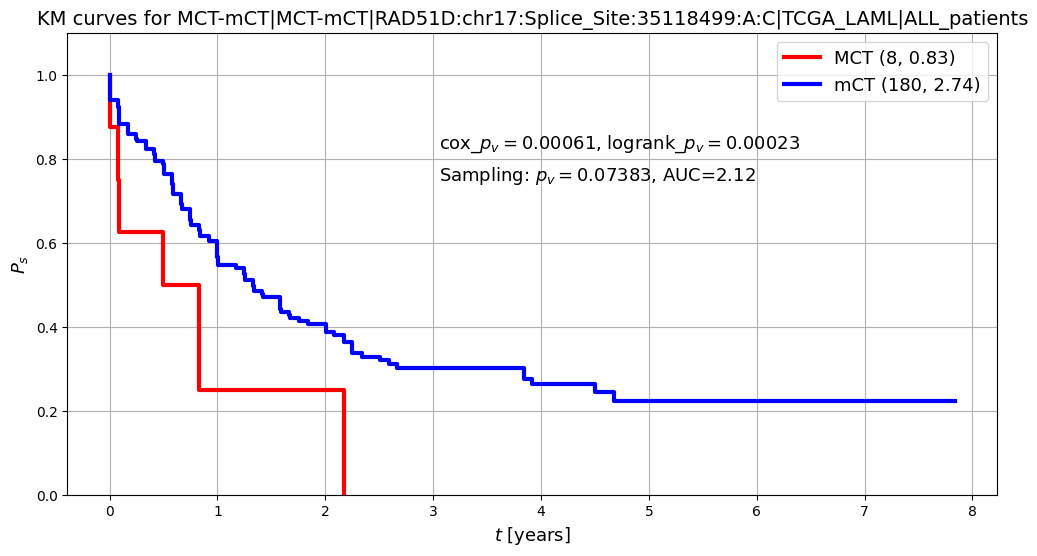

In [6]:
#result_key = ['TPX2', 'MCT-mCT|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_LAML|ALL_patients']
#result_key = ['TPX2', 'mCT-mCt|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_BRCA|immunotherapy']
#result_key = ['TPX2', 'McT-mcT|TPX2:chr20:Splice_Region:31770476:G:T|PAN-cancer|ALL_patients']
#result_key = ['MET', 'McT-mcT|MET:chr7:Splice_Site:116739948:A:T|PAN-cancer|chemotherapy']
#result_key = ['TPX2', 'MCT-mCT|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_LAML|ALL_patients']


#result_key = ['PIK3CA', 'MCT-mCT|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|hormone_therapy']
#result_key = ['PIK3CA', 'MCT-mCT|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|tamoxifen']
#result_key = ['PIK3CA', 'MCT-mCT|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|cyclophosphamide']
#result_key = ['TPX2', 'MCT-mCT|MCT-mCT|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_OV|taxol']
#result_key = ['APBA2', 'MCT-mCT|APBA2:chr15:Splice_Site:29076093:T:G|TCGA_OV|taxol']
#result_key = ['GLG1', 'MCT-mCT|GLG1:chr16:Splice_Site:74483125:C:T|TCGA_BRCA|doxorubicin']
#result_key = ['MYOF', 'MCT-mCT|MYOF:chr10:Splice_Site:93379861:A:C|TCGA_OV|cisplatin']

#result_key = ['RAD51D', 'MCT-mCT|MCT-mCT|RAD51D:chr17:Splice_Site:35118499:A:C|TCGA_GBM|temodar']
#result_key = ['HERC3', 'MCT-mCT|MCT-mCT|HERC3:chr4:Splice_Site:88655306:T:G|TCGA_OV|doxil']
#result_key = ['CAD', 'MCT-mCT|MCT-mCT|CAD:chr2:Splice_Site:27218017:G:T|TCGA_BRCA|hormone_therapy']
#result_key = ['CDON', 'MCT-mCT|MCT-mCT|CDON:chr11:Splice_Site:126021246:A:C|TCGA_OV|carboplatin']

#result_key = ['ATP1A2', 'MCT-mCT|MCT-mCT|ATP1A2:chr1:Splice_Site:160135297:T:G|TCGA_GBM|dexamethasone']
#result_key = ['DYRK4', 'MCT-mCT|MCT-mCT|DYRK4:chr12:Splice_Site:4591300:T:G|TCGA_BRCA|arimidex']
#result_key = ['ANKRD17', 'MCT-mCT|MCT-mCT|ANKRD17:chr4:Splice_Site:73139529:A:C|TCGA_OV|topotecan']
#result_key = ['MSH5', 'MCT-mCT|MCT-mCT|MSH5:chr6:Splice_Site:31759977:T:G|TCGA_GBM|chemotherapy']
#result_key = ['EMC1', 'MCT-mCT|MCT-mCT|EMC1:chr1:Splice_Site:19243612:A:C|TCGA_LUAD|chemotherapy']
#result_key = ['MTMR11', 'MCT-mCT|MCT-mCT|MTMR11:chr1:Splice_Site:149935297:A:C|TCGA_OV|taxol']

#result_key = ['PIK3CA', 'MCT-mCT|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|taxol']
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|arimidex']

#result_key = ['MTMR11', 'MCT-mCT,MCt-mCt|MCT-mCT|MTMR11:chr1:Splice_Site:149935297:A:C|TCGA_BRCA|doxorubicin']

#result_key = ['POLR3B', 'MCT-MCt,mCT-mCt|MCT-MCt|POLR3B:chr12:Splice_Site:106369685:T:G|TCGA_BRCA|docetaxel']
#result_key = ['SPEG', 'MCT-MCt,mCT-mCt|MCT-MCt|SPEG:chr2:Splice_Site:219477787:T:G|TCGA_PAAD|chemotherapy']
#result_key = ['SPEG', 'MCT-MCt,mCT-mCt|MCT-MCt|SPEG:chr2:Splice_Site:219477787:T:G|TCGA_PAAD|gemcitabine']

#result_key = ['SPEG', 'MCT-mCT|SPEG:chr2:Splice_Site:219477787:T:G|TCGA_PAAD|ALL_patients']

#result_key = ['AASS', 'MCT-MCt,mCT-mCt|MCT-MCt|AASS:chr7:Splice_Site:122126373:A:C|TCGA_GBM|dexamethasone']
#result_key = ['ATP1A2', 'MCT-MCt,mCT-mCt|MCT-MCt|ATP1A2:chr1:Splice_Site:160135297:T:G|TCGA_GBM|dexamethasone']
#result_key = ['PRRC2A', 'MCT-MCt,mCT-mCt|MCT-MCt|PRRC2A:chr6:Splice_Site:31629336:T:G|TCGA_GBM|dexamethasone']
#result_key = ['RAD51D', 'MCT-MCt,mCT-mCt|MCT-MCt|RAD51D:chr17:Splice_Site:35118499:A:C|TCGA_GBM|dexamethasone']
#result_key = ['TSHR', 'MCT-MCt,mCT-mCt|MCT-MCt|TSHR:chr14:Intron:81096719:G:T|TCGA_GBM|dexamethasone']
#result_key = ['TSHR', 'MCT-MCt,mCT-mCt|MCT-MCt|TSHR:chr14:Intron:81096719:G:T|TCGA_LUSC|chemotherapy']
#result_key = ['SPTBN1', 'MCT-MCt,mCT-mCt|MCT-MCt|SPTBN1:chr2:Splice_Site:54599245:T:G|TCGA_GBM|dexamethasone']

#result_key = ['MET', 'MCT-mCT|MCT-mCT|MET:chr7:Intron:116769622:TTT:-|TCGA_GBM|chemotherapy']
#result_key = ['PIK3CA', 'MCT-mCT|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|doxorubicin']

#result_key = ['EGFR', 'MCT-MCt,mCT-mCt|MCT-MCt|EGFR:chr7:Intron:55201370:TC:-|TCGA_LGG|bevacizumab']

#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCt-mCt|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|hormone_therapy']
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|tamoxifen']
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCt-mCt|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|tamoxifen']

#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|taxol']
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCt-mCt|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|taxol']

#result_key = ['TPX2', 'MCT-mCT,MCt-mCt|MCt-mCt|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_OV|taxol']
#result_key = ['GLG1', 'MCT-mCT,MCt-mCt|MCt-mCt|GLG1:chr16:Splice_Site:74483125:C:T|TCGA_BRCA|doxorubicin']
#result_key = ['MTMR11', 'MCT-mCT,MCt-mCt|MCt-mCt|MTMR11:chr1:Splice_Site:149935297:A:C|TCGA_BRCA|doxorubicin']
#result_key = ['HERC3', 'MCT-mCT,MCt-mCt|MCt-mCt|HERC3:chr4:Splice_Site:88655306:T:G|TCGA_OV|doxil']
#result_key = ['CAD', 'MCT-mCT,MCt-mCt|MCt-mCt|CAD:chr2:Splice_Site:27218017:G:T|TCGA_BRCA|hormone_therapy']
#result_key = ['ATP1A2', 'MCT-mCT,MCt-mCt|MCt-mCt|ATP1A2:chr1:Splice_Site:160135297:T:G|TCGA_GBM|dexamethasone']
#result_key = ['DYRK4', 'MCT-mCT,MCt-mCt|MCt-mCt|DYRK4:chr12:Splice_Site:4591300:T:G|TCGA_BRCA|arimidex']
#result_key = ['MSH5', 'MCT-mCT,MCt-mCt|MCT-mCT|MSH5:chr6:Splice_Site:31759977:T:G|TCGA_GBM|chemotherapy']
#result_key = ['EMC1', 'MCT-mCT,MCt-mCt|MCt-mCt|EMC1:chr1:Splice_Site:19243612:A:C|TCGA_LUAD|chemotherapy']
#result_key = ['RAD51D', 'MCT-mCT,MCt-mCt|MCt-mCt|RAD51D:chr17:Splice_Site:35118499:A:C|TCGA_GBM|temodar']
#result_key = ['CDON', 'MCT-mCT,MCt-mCt|MCT-mCT|CDON:chr11:Splice_Site:126021246:A:C|TCGA_OV|carboplatin']
#result_key = ['EGFR', 'MCT-MCt,mCT-mCt|mCT-mCt|EGFR:chr7:Intron:55201370:TC:-|TCGA_LGG|bevacizumab']
#result_key = ['POLR3B', 'MCT-MCt,mCT-mCt|mCT-mCt|POLR3B:chr12:Splice_Site:106369685:T:G|TCGA_BRCA|docetaxel']
#result_key = ['SPEG', 'MCT-MCt,mCT-mCt|mCT-mCt|SPEG:chr2:Splice_Site:219477787:T:G|TCGA_PAAD|chemotherapy']
#result_key = ['SPEG', 'MCT-MCt,mCT-mCt|mCT-mCt|SPEG:chr2:Splice_Site:219477787:T:G|TCGA_PAAD|gemcitabine']
#result_key = ['ATP1A2', 'MCT-MCt,mCT-mCt|mCT-mCt|ATP1A2:chr1:Splice_Site:160135297:T:G|TCGA_GBM|dexamethasone']
#result_key = ['PRRC2A', 'MCT-MCt,mCT-mCt|mCT-mCt|PRRC2A:chr6:Splice_Site:31629336:T:G|TCGA_GBM|dexamethasone']
#result_key = ['AASS', 'MCT-MCt,mCT-mCt|mCT-mCt|AASS:chr7:Splice_Site:122126373:A:C|TCGA_GBM|dexamethasone']
#result_key = ['RAD51D', 'MCT-MCt,mCT-mCt|mCT-mCt|RAD51D:chr17:Splice_Site:35118499:A:C|TCGA_GBM|dexamethasone']
#result_key = ['TSHR', 'MCT-MCt,mCT-mCt|mCT-mCt|TSHR:chr14:Intron:81096719:G:T|TCGA_GBM|dexamethasone']
#result_key = ['TSHR', 'MCT-MCt,mCT-mCt|mCT-mCt|TSHR:chr14:Intron:81096719:G:T|TCGA_LUSC|chemotherapy']
#result_key = ['SPTBN1', 'MCT-MCt,mCT-mCt|mCT-mCt|SPTBN1:chr2:Splice_Site:54599245:T:G|TCGA_GBM|dexamethasone']

#result_key = ['BCL9L', 'MCT-mCT,MCt-mCt|MCT-mCT|BCL9L:chr11:Intron:118903196:AG:-|TCGA_OV|paclitaxel']
#result_key = ['BCL9L', 'MCT-mCT,MCt-mCt|MCT-mCT|BCL9L:chr11:Intron:118903196:AG:-|TCGA_OV|carboplatin']
#result_key = ['BCL9L', 'MCT-mCT,MCt-mCt|MCt-mCt|BCL9L:chr11:Intron:118903196:AG:-|TCGA_OV|carboplatin']
#result_key = ['BCL9L', 'MCT-mCT,MCt-mCt|MCt-mCt|BCL9L:chr11:Intron:118903196:AG:-|TCGA_OV|paclitaxel']

# not significant results (we set p threshold to 0.99)
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCT-mCT|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|adriamycin']
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCt-mCt|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|adriamycin']
#result_key = ['PIK3CA', 'MCT-mCT,MCt-mCt|MCt-mCt|PIK3CA:chr3:Intron:179203524:G:C|TCGA_BRCA|cytoxan']

#result_key = ['BCL9L', 'MCT-mCT,MCt-mCt|MCT-mCT|BCL9L:chr11:Intron:118903196:AG:-|TCGA_OV|chemotherapy']
#result_key = ['BCL9L', 'MCT-mCT,MCt-mCt|MCT-mCT|BCL9L:chr11:Intron:118903196:AG:-|TCGA_OV|taxol']

#result_key = ['TPX2', 'MCT-mCT,MCt-mCt|MCT-mCT|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_OV|carboplatin']
#result_key = ['TPX2', 'MCT-mCT,MCt-mCt|MCT-mCT|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_OV|chemotherapy']

#result_key = ['GLG1', 'MCT-mCT,MCt-mCt|MCT-mCT|GLG1:chr16:Splice_Site:74483125:C:T|TCGA_BRCA|cytoxan']  # cyclophosphamide  cytoxan
#result_key = ['GLG1', 'MCT-mCT,MCt-mCt|MCt-mCt|GLG1:chr16:Splice_Site:74483125:C:T|TCGA_BRCA|cytoxan']

#result_key = ['APBA2', 'MCT-mCT,MCt-mCt|MCT-mCT|APBA2:chr15:Splice_Site:29076093:T:G|TCGA_OV|cisplatin']

#result_key = ['MYOF', 'MCT-mCT,MCt-mCt|MCT-mCT|MYOF:chr10:Splice_Site:93379861:A:C|TCGA_OV|carboplatin']

#result_key = ['MTMR11', 'MCT-mCT,MCt-mCt|MCT-mCT|MTMR11:chr1:Splice_Site:149935297:A:C|TCGA_BRCA|adriamycin']

#result_key = ['HERC3', 'MCT-mCT,MCt-mCt|MCT-mCT|HERC3:chr4:Splice_Site:88655306:T:G|TCGA_OV|carboplatin']

#result_key = ['CAD', 'MCT-mCT,MCt-mCt|MCt-mCt|CAD:chr2:Splice_Site:27218017:G:T|TCGA_BRCA|adriamycin']

# result_key = ['ATP1A2', 'MCT-mCT,MCt-mCt|MCT-mCT|ATP1A2:chr1:Splice_Site:160135297:T:G|TCGA_GBM|temodar']

#result_key = ['DYRK4', 'MCT-mCT,MCt-mCt|MCt-mCt|DYRK4:chr12:Splice_Site:4591300:T:G|TCGA_BRCA|cytoxan']

#result_key = ['RAD51D', 'MCT-mCT,MCt-mCt|MCt-mCt|RAD51D:chr17:Splice_Site:35118499:A:C|TCGA_GBM|temozolomide']

#result_key = ['CDON', 'MCT-mCT,MCt-mCt|MCT-mCT|CDON:chr11:Splice_Site:126021246:A:C|TCGA_OV|chemotherapy']
#result_key = ['CDON', 'MCT-mCT,MCt-mCt|MCT-mCT|CDON:chr11:Splice_Site:126021246:A:C|TCGA_OV|taxol']

#result_key = ['EGFR', 'MCT-MCt,mCT-mCt|mCT-mCt|EGFR:chr7:Intron:55201370:TC:-|TCGA_LGG|lomustine']

#result_key = ['TPX2', 'MCT-mCT|MCT-mCT|TPX2:chr20:Splice_Region:31770476:G:T|TCGA_LAML|ALL_patients']
#result_key = ['MTMR11', 'MCT-mCT|MCT-mCT|MTMR11:chr1:Splice_Site:149935297:A:C|TCGA_LAML|ALL_patients']
#result_key = ['GSN', 'MCT-mCT|MCT-mCT|GSN:chr9:Splice_Site:121300007:T:G|TCGA_LIHC|ALL_patients']
#result_key = ['SPEG', 'MCT-mCT|MCT-mCT|SPEG:chr2:Splice_Site:219477787:T:G|TCGA_PAAD|ALL_patients']
#result_key = ['HERC3', 'MCT-mCT|MCT-mCT|HERC3:chr4:Splice_Site:88655306:T:G|TCGA_GBM|ALL_patients']
#result_key = ['CHL1', 'MCT-mCT|MCT-mCT|CHL1:chr3:Splice_Site:401624:A:T|TCGA_LAML|ALL_patients']
#result_key = ['APBA2', 'MCT-mCT|MCT-mCT|APBA2:chr15:Splice_Site:29076093:T:G|TCGA_LUSC|ALL_patients']

#result_key = ['TRPC4AP', 'MCT-mCT|MCT-mCT|TRPC4AP:chr20:Splice_Region:35054969:T:G|TCGA_KIRC|ALL_patients']

#result_key = ['GSN', 'MCT-mCT|MCT-mCT|GSN:chr9:Splice_Site:121300007:T:G|TCGA_PAAD|ALL_patients']

#result_key = ['APBA2', 'MCT-mCT|MCT-mCT|APBA2:chr15:Splice_Site:29076093:T:G|TCGA_CESC|ALL_patients']
#result_key = ['NBPF3', 'MCT-mCT|MCT-mCT|NBPF3:chr1:Splice_Site:21473586:G:T|TCGA_STAD|ALL_patients']
result_key = ['RAD51D', 'MCT-mCT|MCT-mCT|RAD51D:chr17:Splice_Site:35118499:A:C|TCGA_LAML|ALL_patients']
#result_key = ['HERC3', 'MCT-mCT|MCT-mCT|HERC3:chr4:Splice_Site:88655306:T:G|TCGA_CESC|ALL_patients']

figsize = (12,6)
linewidth: int = 3
fontsize: int = 14
group1_color, group2_color = 'red', 'blue'
group1_lbl, group2_lbl = result_key[1].split('|')[1].split('-')
p_value_txt_pos = (0.4, 0.75)

save_fig = False
# RECALL that the OS file names is case insensitive
save_fig_file = report_path / f"survival__{result_key[1].replace(':', '_').replace('-', 'X').replace('|', '__').replace(',', '_')}.png"
# ====================================================================================================================================
gene, r_key = result_key
#title: str = f"KM curves for {','.join(r_key.split('|')[1:])}"
#title: str = f"KM curves for {','.join(r_key.split('|'))}"
title: str = f"KM curves for {r_key}"

fig, ax = ut.plot_gene_muts_survival_result(gene_results[gene][r_key], title,
                                              group1_lbl, group2_lbl,
                                              group1_color=group1_color, group2_color=group2_color,
                                              figsize=figsize, p_value_txt_pos=p_value_txt_pos,
                                              linewidth=linewidth, fontsize=fontsize)

if save_fig:
    plt.savefig(save_fig_file)
    print(f"\nFigure saved in {save_fig_file}.")

# Plot All Results' Curves to PDF

We plot all significant results to a pdf file.

In [7]:
pdf_file_name = pathlib.Path(f"{save_result_base_name}_all_figs.pdf")
exclude_genes: tuple[str] = () #('TPX2', 'MTMR11',)  # results of these genes will be skipped
figsize: tuple = (12, 6,)

# set title_page_text to '' to skip title page
title_page_text: str = f"KM curves and P-values of Significant Cases\n\n\n\n\n\nGenerated: {datetime.datetime.now().replace(microsecond=0)}"

# set description_pages_text_list to [] to skip description pages
mutations_str = '\n'.join(f"{x}. {y}" for x, y in zip(range(1, len(muts_ids)+1), muts_ids))
description_pages_text_list: list[str] = [
    f""" 
Significant differential survival analysis over all cancer types and therapies of B3 splice mutations (and TPX2 mutation). 

Mutation evaluated:
{mutations_str}
""",
]
# ===================================================================================================================================================
plt.ioff()  # disable interactive mode
ut.plot_results_KM_curves_to_pdf(pdf_file_name, gene_results, 
                                 title_page_text=title_page_text,
                                 description_pages_text_list=description_pages_text_list,
                                 figsize=figsize)
plt.ion();  # enable interactive mode

# Extra

## Clinical Data with Drugs
In this section we prepare the variable `df_clinical_drugs_dict` that is used in the `Initialization` section above. We do it here to save time on multiple initializations.

Thus, **no** need to run this section when performing DSA above.

In [ ]:
import data_utils as dtut
import GDC_dataset_feb2021_utils as gdcu

min_drug_prevalence: int = 20  #50 #100  # analyzing only drugs used by at least this number of patients
save_file_name: pathlib.Path = report_path / 'TCGA_clinical_preprocess' / f'df_clinical_drugs_dict_{min_drug_prevalence}.pkl'
save_combined_file_name: pathlib.Path = report_path / 'TCGA_clinical_preprocess' / f'df_clinical_therapies_drugs_dict_{min_drug_prevalence}.pkl'

#Event_col_label: str = 'event'
#Duration_col_label: str = 'duration'

# keys for clinical data of all patients, all patients with no therapy and all patients with a therapy, respectively
#All_name: str = 'ALL_patients'
#None_therapy_name: str = 'NO_therapy'
#All_therapies_name: str = 'ALL_therapies'
# ===========================================================================================================================

# load TCGA clinical data
clinical_data_file: pathlib.Path = pathlib.Path(si.ROOT_path) / 'Data' / 'GDC' / 'Clinical' / 'df_p_all.pkl'
df_clinical = pd.read_pickle(clinical_data_file)

# add event and duration columns (part of this function)
df_clinical_therapies_dict = dtut.prepare_clinical_dfs(df_clinical, gdcu.Therapies, Dsa_data.event_name, Dsa_data.duration_name, 
                                                       clinical_case_id_col=Dsa_data.patient_ID_col, 
                                                       all_name=Dsa_data.All_name, none_therapy_name=Dsa_data.None_therapy_name, all_therapies_name=Dsa_data.All_therapies_name)

# generate clinical data per drug
df_clinical_drugs_dict, _ = gdcu.get_drugs_clinical_dfs(df_clinical_therapies_dict[Dsa_data.All_name], min_drug_prevalence=min_drug_prevalence)

# saving only the drug data
with open(save_file_name, 'wb') as fp:
    pickle.dump(df_clinical_drugs_dict, fp)
print(f"{save_file_name} created.")

# saving combined therapies and drugs data
with open(save_combined_file_name, 'wb') as fp:
    pickle.dump(df_clinical_therapies_dict | df_clinical_drugs_dict, fp)
print(f"{save_combined_file_name} created.")


# ScratchPad

## TOML configuration
**This need to be updated as it is taken from the old version.**

In [ ]:
import DSA_config
import toml_utils as tmut  # just to show the data

print(DSA_config.data)
tmut.print_nested_dicts(DSA_config.data)

print(DSA_config.clinical_data_file)
#display(DSA_config.df_clinical)

for k, v in DSA_config.df_clinical_therapies_dict.items():
    print(k, v.shape[0])

print(DSA_config.Logrank_kwargs)

In [ ]:
import toml_utils as tmut

toml_file = pathlib.Path('./DSA_config/config.toml')
# =================================================
toml_data = tmut.myToml().load(toml_file)
print(toml_data)
tmut.print_nested_dicts(toml_data)


## Concat multiple batch results

In [ ]:
""" 
Concatenating different batch results (both excel and pickle)
"""
batch_indexes: list = list(range(1, 4+1))
base_file_template: str = str(results_path / f"survival_sgnf_splice_list_10_15_M_P_w_wo_batch_?_4")

save_concat: bool = True
save_concat_base_name = base_file_template.split('_batch')[0]
# =================================================================================================
concat_df, concat_d, return_ok_code = ut.concat_batch_DS_result_files(batch_indexes, base_file_template, index_place_holder_str='?')
if return_ok_code:
    display(concat_df)
    if save_concat:
        with open(f"{save_concat_base_name}.pkl", 'wb') as fp:
            pickle.dump(concat_d, fp)
        myut.dfs_to_excel_file([concat_df], save_concat_base_name + '.xlsx', ['Data'])
else:
    print(f"Mismatch between number of cases in concat_df and concat_d !!")

